In [1]:
import ikpy
import sys
import numpy as np
from ikpy import plot_utils
from os.path import abspath
from pypot.creatures import PoppyTorso
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
sys.path.append('./sketchModel')
from sketch_pix2seq_sampling import getAbsoluteStrokes,drawAbsolutePosition

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





In [2]:
strokes = getAbsoluteStrokes('','','./sketchModel/outputs/snapshot','./200.png')


model_params.max_seq_len 129.



----------------------------------------------------------------------------------------------------
is_training: True
Model using gpu.
Input dropout mode = False.
Output dropout mode = False.
Recurrent dropout mode = True.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


-------------------------------------------------------------------

In [3]:
scene_path = abspath('./vrep-sensors/torso_sensors_scene.ttt')
config_path = abspath('./vrep-sensors/torso_vrep_sensors_config.json')
#config_path = abspath('./config/torso_config_cam01.json')
poppy = PoppyTorso(simulator='vrep', scene=scene_path, config=config_path)
#poppy = PoppyTorso(config=config_path)

In [4]:
'''for motor in poppy.motors:
    print(motor.name)
    motor.compliant = True
    motor.goto_position(0, 3)
'''

'for motor in poppy.motors:\n    print(motor.name)\n    motor.compliant = True\n    motor.goto_position(0, 3)\n'

In [5]:
#poppy.bust_y.compliant = True

In [6]:
#poppy.r_elbow_y.goto_position(10.9,0.5)
#poppy.r_arm_z.goto_position(-45,0.5) #Angle, Time

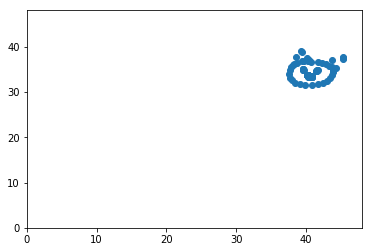

In [7]:
drawAbsolutePosition(strokes,(0,48,0,48))

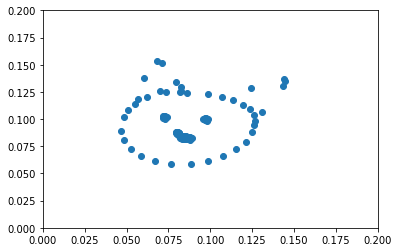

In [8]:
image_size = 0.10
def rescaleImage(strokes,init_size,end_size,xFactor, yFactor):
    new_stroke = []
    for stroke in strokes:
        x = end_size/(init_size/stroke[0])
        y = end_size/(init_size/stroke[1])
        new_stroke.append([x,y,stroke[2]])
    new_stroke = np.asarray(new_stroke)
    
    xMin = np.min(new_stroke[:,0])
    xMax = np.max(new_stroke[:,0])

    yMin = np.min(new_stroke[:,1])
    yMax = np.max(new_stroke[:,1])
    
    
    multiX = end_size/(xMax-xMin)
    multiY = end_size/(yMax-yMin)
    
    new_stroke[:,0] = new_stroke[:,0] * np.floor(multiX)
    new_stroke[:,1] = new_stroke[:,1] * np.floor(multiY)
    new_stroke = moveImage(new_stroke,xFactor,yFactor)
    return new_stroke

def moveImage(stroke_rescale, xFactor, yFactor):
    xMin = np.min(stroke_rescale[:,0])
    yMin = np.min(stroke_rescale[:,1])

    stroke_rescale[:,0] = stroke_rescale[:,0] - (xMin * xFactor)
    stroke_rescale[:,1] = stroke_rescale[:,1] - (yMin * yFactor)
    return stroke_rescale

stroke_rescale = rescaleImage(strokes, 48, image_size,0.90, 0.85)

xMin = np.min(stroke_rescale[:,0])
xMax = np.max(stroke_rescale[:,0])

yMin = np.min(stroke_rescale[:,1])
yMax = np.max(stroke_rescale[:,1])
    
drawAbsolutePosition(stroke_rescale,(0,image_size+0.10,0,image_size+0.10))


# Limite de angulos en VREP

abs_z = -80, 80 <br>
bust_y = -46, 23 <br>
bust_x = -40 40 <br>
l_shoulder_y = -180, 150 <br>
l_shoulder_x = -105, 110 <br>
l_arm_z = -70, 90 <br>
l_elbow_y = -90, 90

# Posición del efector final

El calculo del efector final es computado a partir de las articulación de la cadena y la cinematica del robot
Representa una posición teorica el cual difiere de la real por imperfecciones del modelo.

In [9]:
def getEffector():
    effector = poppy.l_arm_chain.end_effector
    print("X : %.6f" % effector[0] + ", Y : %.6f" % effector[1] + ", Z : %.6f" % effector[2])
    return effector

# Posición de los angulos

Representa los valores de la articulación de la cadena expresado en angulos.

In [10]:
def getDegrees():
    nameMotors = [motor.name for motor in poppy.l_arm_chain.motors]
    mapped = zip(nameMotors, poppy.l_arm_chain.joints_position)
    for motorValue in mapped:
        print(motorValue)

In [11]:
def calc_difference(point,effector):
    result = [0,0,0]
    result[0] = abs(point[0]-effector[0])
    result[1] = abs(point[1]-effector[1])
    result[2] = abs(point[2]-effector[2])
    return result

def mov_poppy_arm(chain, umbral, point):
    iteration = 1
    effector = chain.end_effector
    diff = calc_difference(point, effector)
    while((diff[0] >= umbral[0] or diff[1] >= umbral[1] or diff[2] >= umbral[2]) and iteration <= 50):
        chain.goto((point[0], point[1], point[2]), 0.05, wait=True)
        time.sleep(0.2)
        effector = chain.end_effector
        diff = calc_difference(point, effector)
        iteration += 1
    return iteration

def diff_time(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [12]:
x_umbral = 0.0005
y_umbral = 0.0005
z_umbral = 0.0005

umbral = (x_umbral, y_umbral, z_umbral)

# Dibujar gato

In [13]:
from pypot.vrep import remote_api,vrep_session_id
def drawWithPoppy(planeY, withoutDraw, strokes):
    axisY = planeY
    stroke_i = 0
    size = len(strokes)
    position_draw_log = []
    position_without_draw_log = []
    position_total = []
    auxhandle = remote_api.simxGetObjectHandle(vrep_session_id, 'l_ball', remote_api.simx_opmode_blocking)
    position = remote_api.simxGetObjectPosition(vrep_session_id, auxhandle[1], -1, remote_api.simx_opmode_streaming)
    start = datetime.now()
    for stroke in strokes:
        if stroke[2] == 0:
            axisY = planeY
        else:
            axisY = withoutDraw
        i = mov_poppy_arm(poppy.l_arm_chain, umbral, (stroke[0], axisY, stroke[1]))
        stroke_i += 1
        position = remote_api.simxGetObjectPosition(vrep_session_id, auxhandle[1], -1, remote_api.simx_opmode_buffer)
        if(axisY == planeY):
            position_draw_log.append(position[1])
        else:
            position_without_draw_log.append(position[1])
        position_total.append(position[1])
        print("Move %.d" % stroke_i + " from %.d" % size + " iterations to converge : %.d" % i)
    end = datetime.now()
    diff_time(start, end)
    mov_poppy_arm(poppy.l_arm_chain, umbral, (stroke[0], withoutDraw, stroke[1]))
    return position_total, position_draw_log, position_without_draw_log      
position_total, position_draw_log, position_without_draw_log  = drawWithPoppy(-0.20, -0.14, stroke_rescale)

Move 1 from 130 iterations to converge : 7
Move 2 from 130 iterations to converge : 6
Move 3 from 130 iterations to converge : 3
Move 4 from 130 iterations to converge : 6
Move 5 from 130 iterations to converge : 8
Move 6 from 130 iterations to converge : 5
Move 7 from 130 iterations to converge : 9
Move 8 from 130 iterations to converge : 5
Move 9 from 130 iterations to converge : 5
Move 10 from 130 iterations to converge : 5
Move 11 from 130 iterations to converge : 5
Move 12 from 130 iterations to converge : 13
Move 13 from 130 iterations to converge : 3
Move 14 from 130 iterations to converge : 34
Move 15 from 130 iterations to converge : 20
Move 16 from 130 iterations to converge : 5
Move 17 from 130 iterations to converge : 5
Move 18 from 130 iterations to converge : 5
Move 19 from 130 iterations to converge : 14
Move 20 from 130 iterations to converge : 5
Move 21 from 130 iterations to converge : 5
Move 22 from 130 iterations to converge : 5
Move 23 from 130 iterations to conver

In [14]:
position_draw_log = np.asarray(position_draw_log)
position_without_draw_log = np.asarray(position_without_draw_log)
position_total = np.asarray(position_total)
y_draw = position_draw_log[:,1]
print("VALUES FOR PENCIL DRAWING")
print("Low value : %.6f " % np.min(y_draw))
print("Mean draw: %.6f " % np.mean(y_draw))
print("Median draw: %.6f " % np.median(y_draw))
print("High value : %.6f " % np.max(y_draw))
print("Space of canvas  : %.6f " % (np.min(y_draw)-np.max(y_draw)))

print("----------------------------------------------------------")
print("VALUES FOR PENCIL WITHOUT DRAW")

y_without_draw = position_without_draw_log[:,1]
print("Low value : %.6f " % np.min(y_without_draw))
print("Mean without draw: %.6f " % np.mean(y_without_draw))
print("Median draw: %.6f " % np.median(y_without_draw))
print("High value : %.6f " % np.max(y_without_draw))
print("Space of canvas  : %.6f " % (np.min(y_without_draw)-np.max(y_without_draw)))



VALUES FOR PENCIL DRAWING
Low value : -0.191039 
Mean draw: -0.185440 
Median draw: -0.184909 
High value : -0.183941 
Space of canvas  : -0.007098 
----------------------------------------------------------
VALUES FOR PENCIL WITHOUT DRAW
Low value : -0.128936 
Mean without draw: -0.127174 
Median draw: -0.126833 
High value : -0.125673 
Space of canvas  : -0.003263 


In [15]:
mov_poppy_arm(poppy.l_arm_chain, umbral, (0 0, 0))

SyntaxError: invalid syntax (<ipython-input-15-7278c63d6ae6>, line 1)

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/steven/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/steven/anaconda2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/steven/anaconda2/lib/python2.7/site-packages/pypot-3.1.0-py2.7.egg/pypot/utils/stoppablethread.py", line 130, in _wrapped_target
    self._target()
  File "/home/steven/anaconda2/lib/python2.7/site-packages/pypot-3.1.0-py2.7.egg/pypot/utils/stoppablethread.py", line 205, in run
    make_update_loop(self, self._update)
  File "/home/steven/anaconda2/lib/python2.7/site-packages/pypot-3.1.0-py2.7.egg/pypot/utils/stoppablethread.py", line 183, in make_update_loop
    time.sleep(dt)
  File "/home/steven/anaconda2/lib/python2.7/site-packages/pypot-3.1.0-py2.7.egg/pypot/vrep/__init__.py", line 46, in sleep
    while (self.get_time() - t0) < t:
  File "/home/steven/anaconda2/lib/python2.7

In [ ]:
print("Pencil up %.d" % np.sum(stroke_rescale[:,2]))
def plotAllData(output,save=False,name="Image"):
  plt.plot(np.arange(0,len(output),1),output[:,0],'go-',label='Axis X',c='r')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Output of axis X')
  if save:
    plt.savefig(name + "_Axis_X")
  plt.show()

  plt.plot(np.arange(0,len(output),1),output[:,1],'go-',label='Axis Y',c='b')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Output of axis Y')
  if save:
    plt.savefig(name + "_Axis_Y")
  plt.show()

  plt.plot(np.arange(0,len(output),1),output[:,2],'go-',label='Axis Z',c='c')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Output of axis Z')
  if save:
    plt.savefig(name + "_Axis_Z")
  plt.show()

plotAllData(position_total)